# Liver analysis

**Author**: Alma Andersson<br>
**Description**:<br>

Joint spatial analysis of the entire dataset. The analysis is separated into three parts

- Data Loading and processing
- Feature by distance analysis
- Classification of structures

### Data loading and processing
A brief section loading and processing the data.


### Feature by distance analysis
Here, expression as a function of distance (_feature by distance_) is exemplified, as well as the slightly modified variant where the log-ratio between distances to two different structure classes (here portal and central veins) is examined.


### Classification
This section illustrates how the type of a vein can be predicted based on its neighborhood expression profile (NEP). Included in the analysis is the creation of NEPs, a two step procedure where a neighborhood is first identified, from which a weighted gene expression (by distance) is then assembled. Once the NEPs are formed, a _logistic regression_ model is trained to predict vein type based on the NEP. Cross validation is also implemented to assess performance.


<hr>

### Load libraries

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt
from matplotlib import rcParams

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

from hepaquery.structures import VeinData, Model
import hepaquery.visual as viz
import hepaquery.utils as ut

import re
import datetime


In [4]:
t = ad.read_h5ad("/Users/franziskahildebrandt/P.Berghei-Liver/ST-mLiver/data/h5ad/veins_only/12h/ctrl/")

IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Tue Dec 20 09:42:46 2022
, filename = '/Users/franziskahildebrandt/P.Berghei-Liver/ST-mLiver/data/h5ad/veins_only/12h/ctrl/', file descriptor = 75, errno = 21, error message = 'Is a directory', buf = 0x7ff7affd2f28, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [4]:
t.obsm["vein_distances"]

dist_type_ambigious  dist_type_central  dist_type_portal
9x17           1241.581092        1117.943132       1079.148315
9x19           1206.231766        1054.161597        978.836019
9x21           1181.945991        1000.925695        883.954437
9x23           1170.737256         961.757539        798.651140
9x25           1172.920831         937.327368        723.514669
...                    ...                ...               ...
65x23           828.090714        1014.673657       1143.365659
65x25           786.334588        1047.848922       1072.356025
65x27           762.569673        1093.619799       1011.677293
65x29           756.689885        1150.945238        961.944396
65x31           772.645514        1219.728695        929.488833

[763 rows x 3 columns]

In [5]:
rcParams["figure.facecolor"] = "white"

### Global Variables

Here certain global variables are set, which will be used to save output and load data. A brief explanation is provided below:

- TAG : Unique identifier for the analysis. All results will be saved in a folder called "TAG-analysis" within the res-folder.
- REPO\_DIR : Path to the repository directory, only change this if files are moved around.
- DATA_DIR : Path to the data being loaded.
- GENE_LIST_DIR : Directory to lists of genes
- SCALE_FACTOR : Scaling factor between pixels to $\mu m$

In [6]:

TAG = re.sub(":| |-|\\.|","",str(datetime.datetime.today()))
TAG = TAG + "-predict"

REPO_DIR = osp.dirname(osp.abspath(os.getcwd()))
DATA_DIR = osp.join("/Users/franziskahildebrandt/P.Berghei-Liver/ST-mLiver/data/h5ad/veins_only/")
RESULTS_DIR = osp.join(REPO_DIR,"/Users/franziskahildebrandt/P.Berghei-Liver/ST-mLiver/res",TAG)

if not osp.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
    
GENE_LIST_DIR = osp.join(REPO_DIR,"/Users/franziskahildebrandt/P.Berghei-Liver/ST-mLiver/data/gene-lists/veins")


SCALE_FACTOR = 2.8

SAVE_RESULTS = False

In [7]:
# Get data paths
PTHS = list(filter(lambda x: x.endswith("h5ad"),os.listdir(DATA_DIR)))
PTHS = {p:osp.join(DATA_DIR,p) for p in PTHS }

data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}
new_names = {k:d.uns["sample"] + "-" + d.uns["replicate"] for k,d in data_set.items()}
data_set = dict((new_names[k],d) for k,d in data_set.items())
    
data_set

{'CN63-D2.yaml': AnnData object with n_obs × n_vars = 810 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN29-C1.yaml': AnnData object with n_obs × n_vars = 811 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN31-E1.yaml': AnnData object with n_obs × n_vars = 513 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN53-E1.yaml': AnnData object with n_obs × n_vars = 656 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN71-C2.yaml': AnnData object with n_obs × n_vars = 825 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: '

In [8]:
exclude = ["CN54-E2.yaml", "CN31-E1.yaml", "CN57-D1.yaml", "CN51-C2.yaml", "CN55-C1.yaml"]

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN63-D2.yaml': AnnData object with n_obs × n_vars = 810 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN29-C1.yaml': AnnData object with n_obs × n_vars = 811 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN53-E1.yaml': AnnData object with n_obs × n_vars = 656 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN71-C2.yaml': AnnData object with n_obs × n_vars = 825 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN70-C2.yaml': AnnData object with n_obs × n_vars = 630 × 16198
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: '

In [15]:
data_set["CN63-D2.yaml"].obsm["vein_distances"]

dist_type_ambigious  dist_type_central  dist_type_portal
23x27          3738.949041        3310.316264       3089.259732
23x29          3728.943672        3302.068196       3080.595749
24x24          3749.114879        3317.308777       3096.989561
24x26          3739.272423        3309.076562       3088.369330
24x28          3729.636947        3301.306532       3080.157680
...                    ...                ...               ...
65x41          3509.230945        3063.220087       2845.498955
65x43          3499.492481        3055.210042       2837.046704
65x45          3490.326022        3047.778434       2829.176216
65x47          3480.792355        3040.018914       2820.970520
65x49          3471.371940        3032.358545       2812.870773

[810 rows x 3 columns]

In [9]:
use_short_filter = True

pths = listdir(osp.join(GENE_LIST_DIR))
if use_short_filter:
    pths = list(filter(lambda x: "_short" in x,pths))
else:
    pths = list(filter(lambda x: "_short" not in x,pths))
#read gene lists
genes = dict()
for filename in pths:
    name = '.'.join(filename.split(".")[0:-1])
    with open(osp.join(GENE_LIST_DIR,filename),"r+") as f:
        _gs = f.readlines()
        _gs = [x.replace("\n","") for x in _gs]
        genes.update({name:_gs})
        
# create an additional entry called "all" by joining 
# all existing lists
genes["all"] = reduce(lambda x,y : x + y,list(genes.values()))

In [10]:
genes

{'portal_short': ['Sds', 'Cyp2f2', 'Hal', 'Hsd17b13', 'Aldh1b1'],
 'central_short': ['Glul', 'Oat', 'Slc1a2', 'Cyp2e1', 'Cyp2a5'],
 'all': ['Sds',
  'Cyp2f2',
  'Hal',
  'Hsd17b13',
  'Aldh1b1',
  'Glul',
  'Oat',
  'Slc1a2',
  'Cyp2e1',
  'Cyp2a5']}

Visualize the data to make sure everything looks as expected

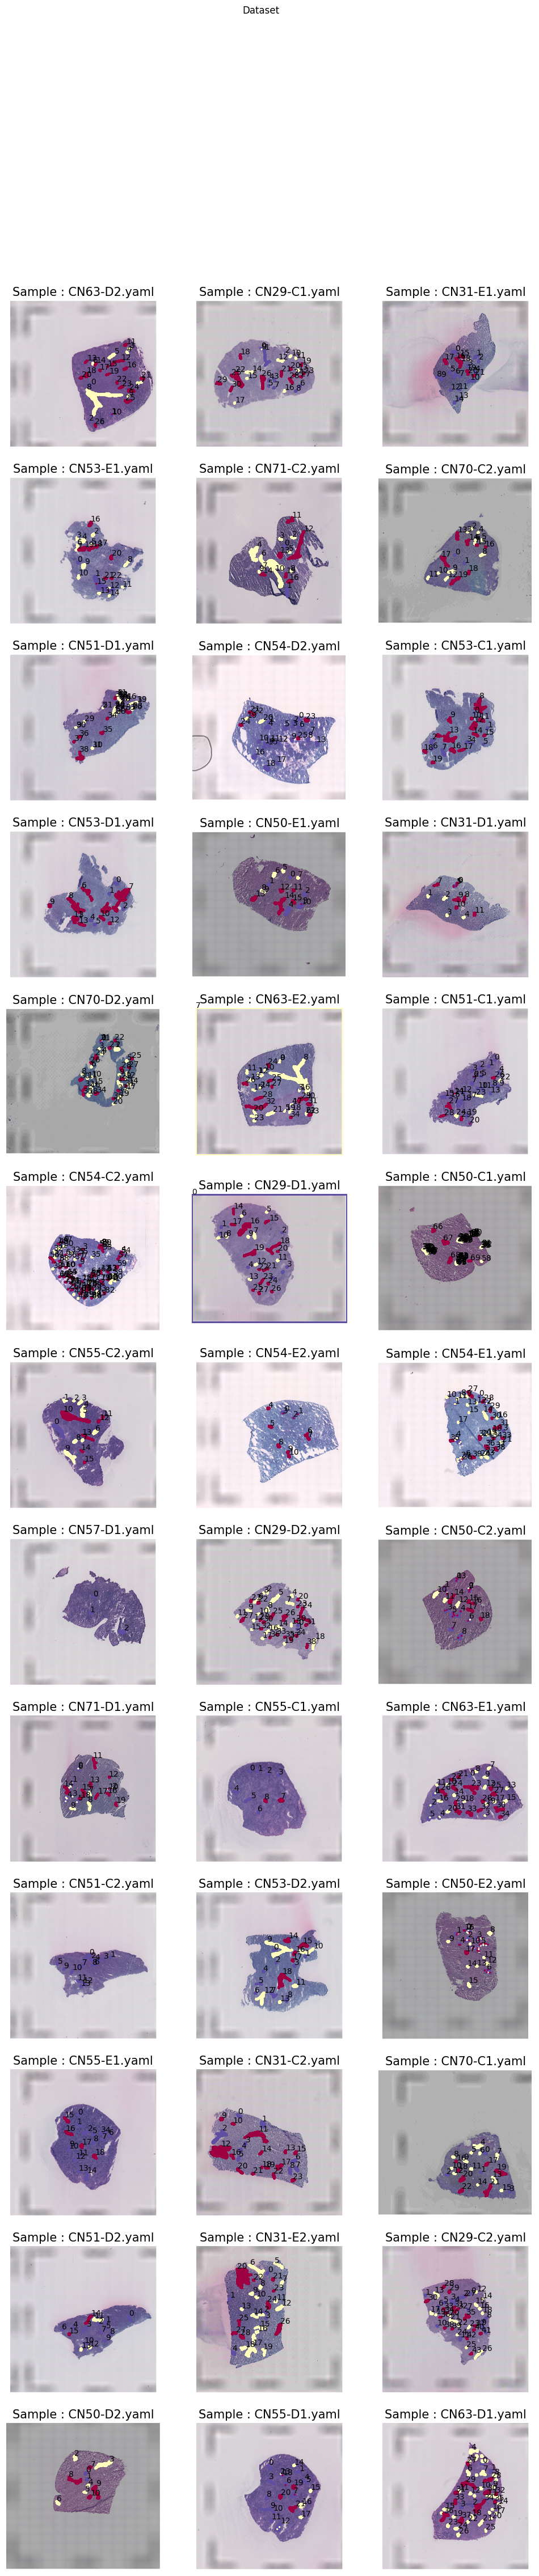

In [46]:
n_veins = len(data_set)
spot_size = 20
side_size =4

fig,ax = viz.get_figure(n_veins,n_cols = 3, side_size = side_size)

for k,(sample_id,data) in enumerate(data_set.items()):
    
    viz.plot_veins(ax[k],data,
                   show_image=True,
                   show_id=True)
    
    ax[k].set_title("Sample : {}".format(sample_id),
                   fontsize = 15,
                   )
    
fig.suptitle("Dataset")
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"dataset-display.png"))
plt.show()

## Analysis : Expression by distance

Model gene expression as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes (blue) represent 1 standard error.

KeyError: 'dist_type_central'

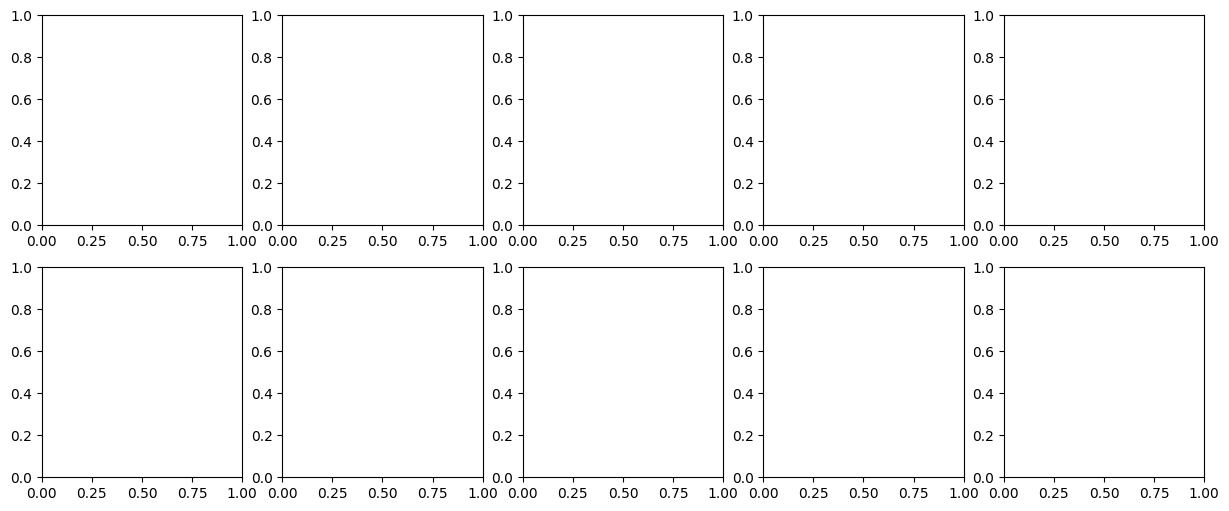

In [11]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 142

# which genes to be assessed
vein_genes = genes["all"]

#define how many columns to plot
n_cols = 5 

# distance values to use

colormap = dict(central = {"envelope":"red",
                           "fitted":"red",
                           "background":"red"},
                portal = {"envelope":"blue",
                           "fitted":"blue",
                           "background":"blue"}
               )

fig,ax = viz.get_figure(len(vein_genes),
                       n_cols = n_cols,
                       side_size = 3,
                      )
# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    
    for vt in ["central", "portal"]:

        xs = np.array([])
        ys = np.array([])
        
        for data in data_set.values():
            if gene not in data.var.gene.values:
                print("can't find {}".format(gene))
                continue
            elif not data.obs_vector(gene).sum() > 1:
                print("no expression of {}".format(gene))
                continue
            
            
            min_dist = data.obsm["vein_distances"]["dist_type_" + vt].values
            xs = np.append(xs,min_dist)
            ys = np.append(ys,data.obs_vector(gene))
        
        if len(xs) > 0:
            smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
            viz.plot_expression_by_distance(ax[k],
                                            data = smoothed,
                                            curve_label = vt,
                                            color_scheme = colormap[vt],
                                            include_background = False,
                                            feature_type = "Gene",
                                            feature = gene,
                                            distance_scale_factor = SCALE_FACTOR,
                                            title_fontsize = 18,
                                            label_fontsize = 15,
                                            tick_fontsize = 12,
                                            distance_unit = "um",
                                          )
            ax[k].set_xlabel("")
        if k % n_cols != 0: ax[k].set_ylabel("")

fig.tight_layout()

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,
                         "feature-by-distance.svg"),
                facecolor = "white",
                dpi = 600)
    
plt.show()

KeyError: 'log(central/portal)'

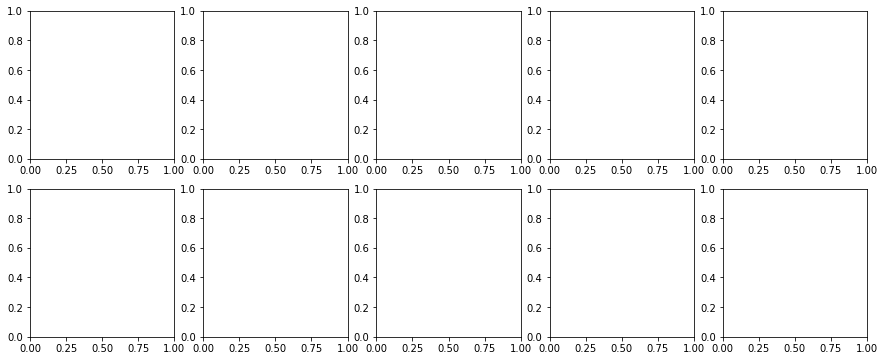

In [45]:
# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = np.log(10)

# which genes to be assessed
vein_genes = genes["all"]


fig,ax = viz.get_figure(n_elements=len(vein_genes),
                        n_cols = 5,
                       side_size = 3,
                       )
# --- plot settings

# iterate over each gene
#for k,gene in enumerate(vein_genes):
for k,gene in enumerate(vein_genes):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            print("can't find {}".format(gene))
            continue
        elif not data.obs_vector(gene).sum() > 1:
            print("no expression of {}".format(gene))
            continue
                
        dist = data.obsm["vein_distances"]["log(central/portal)"].values
        xs = np.append(xs,dist)
        ys = np.append(ys,data.obs_vector(gene))

    if len(xs) > 0:
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        viz.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       flavor ="logodds",
                                       feature = gene,
                                       color_scheme = {"envelope":"gray"},
                                       include_background = False,
                                       feature_type = "Gene",
                                       title_fontsize = 18,
                                       label_fontsize = 15,
                                       tick_fontsize = 12,
                                      )
        ax[k].set_xlabel("")
        if k % n_cols != 0: ax[k].set_ylabel("")
        
fig.tight_layout()
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"feature-by-distance-ratio.svg"),
                facecolor = "white", dpi = 600)
plt.show()

## Analysis : Classification

Begin by assembling representative (mean expression) vectors for neighborhoods around respective vein type and each individual vein. Then proceed to train a predictor (Logistic Regression) and see how it performs on the given data (this is just a prototype).

### Prepare data
Create the necessary mean expression profiles

In [49]:
vein_data = VeinData(data_set = data_set,
                    radius = 71,
                    use_genes = genes["all"],
                    weight_by_distance = True,
                    sigma = 20,
                    verbose = True,
                   )


Sample : CN63-D2.yaml | Vein 0 | Spots used : 0
Sample : CN63-D2.yaml | Vein 1 | Spots used : 0
Sample : CN63-D2.yaml | Vein 2 | Spots used : 0
Sample : CN63-D2.yaml | Vein 3 | Spots used : 0
Sample : CN63-D2.yaml | Vein 4 | Spots used : 0
Sample : CN63-D2.yaml | Vein 5 | Spots used : 0
Sample : CN63-D2.yaml | Vein 6 | Spots used : 0
Sample : CN63-D2.yaml | Vein 7 | Spots used : 0


/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/l

Sample : CN63-D2.yaml | Vein 8 | Spots used : 0
Sample : CN63-D2.yaml | Vein 9 | Spots used : 0
Sample : CN63-D2.yaml | Vein 10 | Spots used : 0
Sample : CN63-D2.yaml | Vein 11 | Spots used : 0
Sample : CN63-D2.yaml | Vein 12 | Spots used : 0
Sample : CN63-D2.yaml | Vein 13 | Spots used : 0
Sample : CN63-D2.yaml | Vein 14 | Spots used : 0
Sample : CN63-D2.yaml | Vein 15 | Spots used : 0
Sample : CN63-D2.yaml | Vein 16 | Spots used : 0
Sample : CN63-D2.yaml | Vein 17 | Spots used : 0
Sample : CN63-D2.yaml | Vein 18 | Spots used : 0
Sample : CN63-D2.yaml | Vein 19 | Spots used : 0


/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/l

Sample : CN63-D2.yaml | Vein 20 | Spots used : 0
Sample : CN63-D2.yaml | Vein 21 | Spots used : 0
Sample : CN63-D2.yaml | Vein 22 | Spots used : 0
Sample : CN63-D2.yaml | Vein 23 | Spots used : 0
Sample : CN63-D2.yaml | Vein 24 | Spots used : 0
Sample : CN63-D2.yaml | Vein 25 | Spots used : 0
Sample : CN63-D2.yaml | Vein 26 | Spots used : 0


/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/l

Sample : CN29-C1.yaml | Vein 0 | Spots used : 5
Sample : CN29-C1.yaml | Vein 1 | Spots used : 16
Sample : CN29-C1.yaml | Vein 2 | Spots used : 4
Sample : CN29-C1.yaml | Vein 3 | Spots used : 4
Sample : CN29-C1.yaml | Vein 4 | Spots used : 4
Sample : CN29-C1.yaml | Vein 5 | Spots used : 4
Sample : CN29-C1.yaml | Vein 6 | Spots used : 4
Sample : CN29-C1.yaml | Vein 7 | Spots used : 4
Sample : CN29-C1.yaml | Vein 8 | Spots used : 3
Sample : CN29-C1.yaml | Vein 9 | Spots used : 4
Sample : CN29-C1.yaml | Vein 10 | Spots used : 4
Sample : CN29-C1.yaml | Vein 11 | Spots used : 3
Sample : CN29-C1.yaml | Vein 12 | Spots used : 7
Sample : CN29-C1.yaml | Vein 13 | Spots used : 3
Sample : CN29-C1.yaml | Vein 14 | Spots used : 9
Sample : CN29-C1.yaml | Vein 15 | Spots used : 4
Sample : CN29-C1.yaml | Vein 16 | Spots used : 4
Sample : CN29-C1.yaml | Vein 17 | Spots used : 4
Sample : CN29-C1.yaml | Vein 18 | Spots used : 7
Sample : CN29-C1.yaml | Vein 19 | Spots used : 4
Sample : CN29-C1.yaml | Vein 

Sample : CN54-D2.yaml | Vein 18 | Spots used : 9
Sample : CN54-D2.yaml | Vein 19 | Spots used : 5
Sample : CN54-D2.yaml | Vein 20 | Spots used : 8
Sample : CN54-D2.yaml | Vein 21 | Spots used : 4
Sample : CN54-D2.yaml | Vein 22 | Spots used : 5
Sample : CN54-D2.yaml | Vein 23 | Spots used : 6
Sample : CN54-D2.yaml | Vein 24 | Spots used : 5
Sample : CN54-D2.yaml | Vein 25 | Spots used : 5
Sample : CN53-C1.yaml | Vein 0 | Spots used : 3
Sample : CN53-C1.yaml | Vein 1 | Spots used : 4
Sample : CN53-C1.yaml | Vein 2 | Spots used : 10
Sample : CN53-C1.yaml | Vein 3 | Spots used : 4
Sample : CN53-C1.yaml | Vein 4 | Spots used : 5
Sample : CN53-C1.yaml | Vein 5 | Spots used : 3
Sample : CN53-C1.yaml | Vein 6 | Spots used : 5
Sample : CN53-C1.yaml | Vein 7 | Spots used : 9
Sample : CN53-C1.yaml | Vein 8 | Spots used : 28
Sample : CN53-C1.yaml | Vein 9 | Spots used : 9
Sample : CN53-C1.yaml | Vein 10 | Spots used : 4
Sample : CN53-C1.yaml | Vein 11 | Spots used : 8
Sample : CN53-C1.yaml | Vein

/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Sample : CN63-E2.yaml | Vein 8 | Spots used : 81
Sample : CN63-E2.yaml | Vein 9 | Spots used : 6
Sample : CN63-E2.yaml | Vein 10 | Spots used : 4
Sample : CN63-E2.yaml | Vein 11 | Spots used : 5
Sample : CN63-E2.yaml | Vein 12 | Spots used : 9
Sample : CN63-E2.yaml | Vein 13 | Spots used : 7
Sample : CN63-E2.yaml | Vein 14 | Spots used : 5
Sample : CN63-E2.yaml | Vein 15 | Spots used : 4
Sample : CN63-E2.yaml | Vein 16 | Spots used : 4
Sample : CN63-E2.yaml | Vein 17 | Spots used : 4
Sample : CN63-E2.yaml | Vein 18 | Spots used : 6
Sample : CN63-E2.yaml | Vein 19 | Spots used : 5
Sample : CN63-E2.yaml | Vein 20 | Spots used : 10
Sample : CN63-E2.yaml | Vein 21 | Spots used : 10
Sample : CN63-E2.yaml | Vein 22 | Spots used : 5
Sample : CN63-E2.yaml | Vein 23 | Spots used : 4
Sample : CN63-E2.yaml | Vein 24 | Spots used : 4
Sample : CN63-E2.yaml | Vein 25 | Spots used : 7
Sample : CN63-E2.yaml | Vein 26 | Spots used : 8
Sample : CN63-E2.yaml | Vein 27 | Spots used : 3
Sample : CN63-E2.ya

/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy-1.24.0rc2-py3.10-macosx-12-x86_64.egg/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Sample : CN29-D1.yaml | Vein 7 | Spots used : 7
Sample : CN29-D1.yaml | Vein 8 | Spots used : 4
Sample : CN29-D1.yaml | Vein 9 | Spots used : 4
Sample : CN29-D1.yaml | Vein 10 | Spots used : 4
Sample : CN29-D1.yaml | Vein 11 | Spots used : 4
Sample : CN29-D1.yaml | Vein 12 | Spots used : 4
Sample : CN29-D1.yaml | Vein 13 | Spots used : 4
Sample : CN29-D1.yaml | Vein 14 | Spots used : 7
Sample : CN29-D1.yaml | Vein 15 | Spots used : 6
Sample : CN29-D1.yaml | Vein 16 | Spots used : 22
Sample : CN29-D1.yaml | Vein 17 | Spots used : 5
Sample : CN29-D1.yaml | Vein 18 | Spots used : 18
Sample : CN29-D1.yaml | Vein 19 | Spots used : 14
Sample : CN29-D1.yaml | Vein 20 | Spots used : 4
Sample : CN29-D1.yaml | Vein 21 | Spots used : 6
Sample : CN29-D1.yaml | Vein 22 | Spots used : 3
Sample : CN29-D1.yaml | Vein 23 | Spots used : 8
Sample : CN29-D1.yaml | Vein 24 | Spots used : 4
Sample : CN29-D1.yaml | Vein 25 | Spots used : 3
Sample : CN29-D1.yaml | Vein 26 | Spots used : 4
Sample : CN29-D1.yam

Sample : CN29-D2.yaml | Vein 14 | Spots used : 12
Sample : CN29-D2.yaml | Vein 15 | Spots used : 3
Sample : CN29-D2.yaml | Vein 16 | Spots used : 7
Sample : CN29-D2.yaml | Vein 17 | Spots used : 4
Sample : CN29-D2.yaml | Vein 18 | Spots used : 12
Sample : CN29-D2.yaml | Vein 19 | Spots used : 3
Sample : CN29-D2.yaml | Vein 20 | Spots used : 3
Sample : CN29-D2.yaml | Vein 21 | Spots used : 5
Sample : CN29-D2.yaml | Vein 22 | Spots used : 4
Sample : CN29-D2.yaml | Vein 23 | Spots used : 3
Sample : CN29-D2.yaml | Vein 24 | Spots used : 21
Sample : CN29-D2.yaml | Vein 25 | Spots used : 8
Sample : CN29-D2.yaml | Vein 26 | Spots used : 8
Sample : CN29-D2.yaml | Vein 27 | Spots used : 5
Sample : CN29-D2.yaml | Vein 28 | Spots used : 5
Sample : CN29-D2.yaml | Vein 29 | Spots used : 4
Sample : CN29-D2.yaml | Vein 30 | Spots used : 4
Sample : CN29-D2.yaml | Vein 31 | Spots used : 4
Sample : CN29-D2.yaml | Vein 32 | Spots used : 4
Sample : CN29-D2.yaml | Vein 33 | Spots used : 4
Sample : CN29-D2.

Sample : CN55-E1.yaml | Vein 16 | Spots used : 10
Sample : CN55-E1.yaml | Vein 17 | Spots used : 6
Sample : CN55-E1.yaml | Vein 18 | Spots used : 7
Sample : CN31-C2.yaml | Vein 0 | Spots used : 6
Sample : CN31-C2.yaml | Vein 1 | Spots used : 10
Sample : CN31-C2.yaml | Vein 2 | Spots used : 13
Sample : CN31-C2.yaml | Vein 3 | Spots used : 6
Sample : CN31-C2.yaml | Vein 4 | Spots used : 5
Sample : CN31-C2.yaml | Vein 5 | Spots used : 6
Sample : CN31-C2.yaml | Vein 6 | Spots used : 7
Sample : CN31-C2.yaml | Vein 7 | Spots used : 8
Sample : CN31-C2.yaml | Vein 8 | Spots used : 7
Sample : CN31-C2.yaml | Vein 9 | Spots used : 4
Sample : CN31-C2.yaml | Vein 10 | Spots used : 5
Sample : CN31-C2.yaml | Vein 11 | Spots used : 33
Sample : CN31-C2.yaml | Vein 12 | Spots used : 27
Sample : CN31-C2.yaml | Vein 13 | Spots used : 5
Sample : CN31-C2.yaml | Vein 14 | Spots used : 6
Sample : CN31-C2.yaml | Vein 15 | Spots used : 5
Sample : CN31-C2.yaml | Vein 16 | Spots used : 7
Sample : CN31-C2.yaml | V

Sample : CN63-D1.yaml | Vein 0 | Spots used : 6
Sample : CN63-D1.yaml | Vein 1 | Spots used : 7
Sample : CN63-D1.yaml | Vein 2 | Spots used : 5
Sample : CN63-D1.yaml | Vein 3 | Spots used : 6
Sample : CN63-D1.yaml | Vein 4 | Spots used : 26
Sample : CN63-D1.yaml | Vein 5 | Spots used : 5
Sample : CN63-D1.yaml | Vein 6 | Spots used : 9
Sample : CN63-D1.yaml | Vein 7 | Spots used : 13
Sample : CN63-D1.yaml | Vein 8 | Spots used : 10
Sample : CN63-D1.yaml | Vein 9 | Spots used : 4
Sample : CN63-D1.yaml | Vein 10 | Spots used : 5
Sample : CN63-D1.yaml | Vein 11 | Spots used : 5
Sample : CN63-D1.yaml | Vein 12 | Spots used : 8
Sample : CN63-D1.yaml | Vein 13 | Spots used : 15
Sample : CN63-D1.yaml | Vein 14 | Spots used : 3
Sample : CN63-D1.yaml | Vein 15 | Spots used : 11
Sample : CN63-D1.yaml | Vein 16 | Spots used : 6
Sample : CN63-D1.yaml | Vein 17 | Spots used : 4
Sample : CN63-D1.yaml | Vein 18 | Spots used : 5
Sample : CN63-D1.yaml | Vein 19 | Spots used : 4
Sample : CN63-D1.yaml | V

In [116]:
model = Model(vein_data,
              verbose=False)

### Train and Predict with classifier

use the `LogisticRegression` module from `sklearn` to create a classifier (binary classification into portal and central veins). We use a l2 penalty to reduce the extent of overfitting and also prevent the weights to blow up.

In [117]:
k = 1
exclude_class = "ambigious"
validate_by = "sample"

results,auc_res = model.cross_validation(k=k,
                                         exclude_class=exclude_class,
                                         by = validate_by,
                                         verbose = False,
                                         auc = True,
                                         )
display(results)
print("Average Accuracy {}".format(results["accuracy"].mean()))

if SAVE_RESULTS:
    if isinstance(exclude_class,list):
        exclude_class = "_".join(exclude_class)
    
    basename = f'CV-{k}-EX-{exclude_class}-BY-{validate_by}.tsv'
    results.to_csv(osp.join(RESULTS_DIR,basename),
                   sep = "\t",
                
                  )


pred_on                                           train_on  accuracy  \
0   CN63-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.709677   
1   CN55-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.777778   
2   CN29-C2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.903226   
3   CN31-E2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.833333   
4   CN51-D2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.600000   
5   CN50-E2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.545455   
6   CN53-D2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.900000   
7   CN71-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.785714   
8   CN54-E1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN71...  0.550000   
9   CN55-C2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN54-E1.yaml, CN71...  0.866667   
10  CN50-E1.yaml  CN53-E1.yaml, CN55-C2.yaml, CN54-E1.yaml, CN71...  0.545455   
11  CN53-E1.yaml  CN50-E1.yaml, CN55-C2.yaml, CN54-E1.yaml, CN71...  0.619048   

         AUC  
0   0.772727  
1   0.850000  
2   0.970833  
3   0.859259  
4   1.000000  
5   0.611111  
6   1.000000  
7   0.975000  
8   0.776942  
9   0.814815  
10  0.366667  
11  0.778846

Average Accuracy 0.7196959999379354


Inspect the results using a ROC curve, we will let the ROC curve represent the average of or k-fold validation

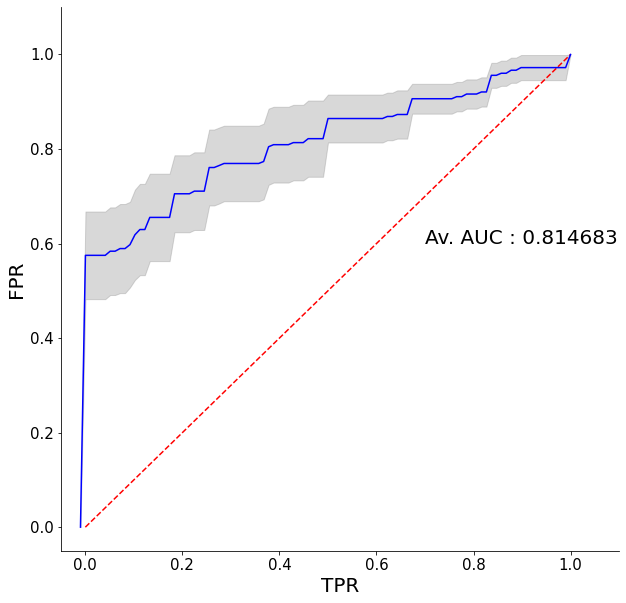

In [118]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
mean_fpr = np.linspace(-0.01,1,100)
inter_tpr = np.zeros((len(auc_res),mean_fpr.shape[0]))
nsq = np.sqrt(len(auc_res))
for k,vals in enumerate(auc_res.values()):
    fpr,tpr,thr = list(vals.values())
    inter_tpr[k,:] = np.interp(mean_fpr, fpr, tpr)
    
mean_tpr = inter_tpr.mean(axis=0)
std_tpr = inter_tpr.std(axis=0)
ax.plot([0,1],[0,1],color = "red",linestyle = "dashed")
ax.plot(mean_fpr,mean_tpr,color = "blue")
ax.fill_between(mean_fpr,mean_tpr - std_tpr / nsq,
                mean_tpr + std_tpr/nsq,
                alpha = 0.3,
                color = "gray",
               )
ax.set_xlim([-0.05,1.1])
ax.set_ylim([-0.05,1.1])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylabel("FPR",fontsize = 20)
ax.set_xlabel("TPR",fontsize = 20)

ax.text(0.7,0.6,"Av. AUC : {:03f}".format(results["AUC"].mean()),fontsize = 20)


ax.tick_params(axis='both', which='major', labelsize=15)


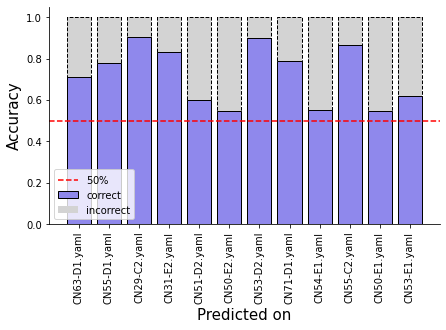

In [119]:
fig,ax = viz.visualize_prediction_result(results)

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,basename.replace("tsv","png")),
               facecolor = "white",
               )


Finally we can visualize the prediction on the tissue, showing the predicted and true labels for respective vein

In [120]:
k = 1
exclude_class = ["ambigious", "ROI", "parasite"]
validate_by = "sample"

results = model.cross_validation(k=1,
                                 exclude_class= exclude_class,
                                 by = "sample",
                                 verbose = False,
                                 )
if SAVE_RESULTS:
    if isinstance(exclude_class,list):
        exclude_class = "_".join(exclude_class)
    
    basename = f'CV-{k}-EX-{exclude_class}-BY-{validate_by}.tsv'
    results.to_csv(osp.join(RESULTS_DIR,basename),
                   sep = "\t",
                  )

display(results)

[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Training :  some excluded cl

pred_on                                           train_on  accuracy
0   CN63-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.709677
1   CN55-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.777778
2   CN29-C2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.903226
3   CN31-E2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.833333
4   CN51-D2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.600000
5   CN50-E2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.545455
6   CN53-D2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.900000
7   CN71-D1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN54...  0.785714
8   CN54-E1.yaml  CN53-E1.yaml, CN50-E1.yaml, CN55-C2.yaml, CN71...  0.550000
9   CN55-C2.yaml  CN53-E1.yaml, CN50-E1.yaml, CN54-E1.yaml, CN71...  0.866667
10  CN50-E1.yaml  CN53-E1.yaml, CN55-C2.yaml, CN54-E1.yaml, CN71...  0.545455
11  CN53-E1.yaml  CN50-E1.yaml, CN55-C2.yaml, CN54-E1.yaml, CN71...  0.619048

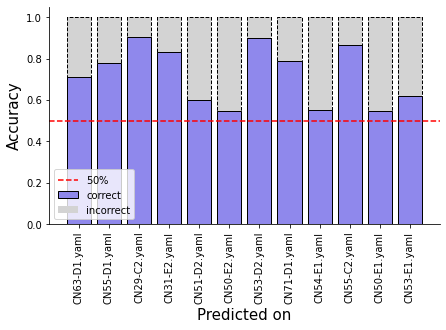

In [121]:
fig,ax = viz.visualize_prediction_result(results)
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,basename.replace("tsv","png")),
               facecolor = "white",
               )

## Prediction on unknown veins

In [122]:
model.fit(train_on = "all",
          verbose=True,
          exclude_class=["ambigious"])

predict = model.predict(predict_on="all",
                        exclude_class=["portal","central"],
                        return_probs = True,
                       )

[INFO] : Training on samples: all
[INFO] : >In Training :  some excluded classes not present in the data
[INFO] : Accuracy on training data is >> 75.676%
[INFO] : >In Test | some excluded classes not present in the data


Vein : CN63-D1.yaml_1 | P(central) : 0.07234250855333146 | P(portal) : 0.9276574914466685


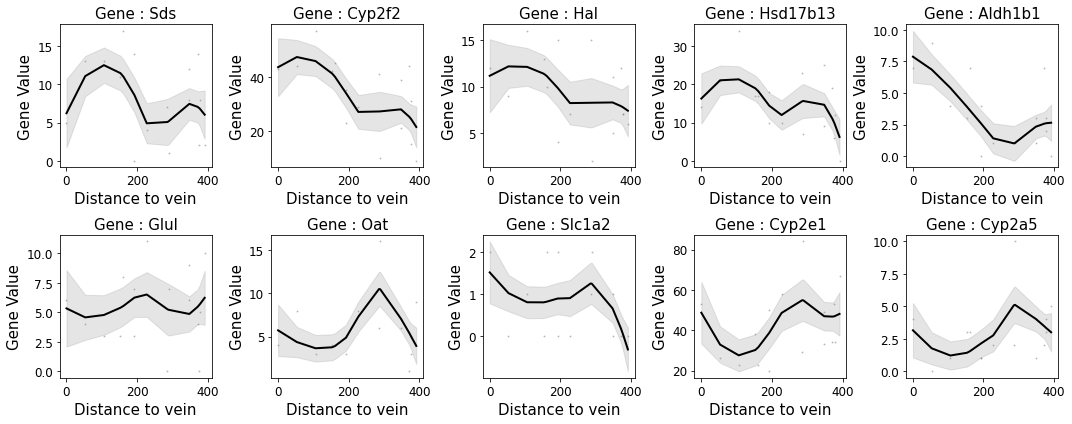

In [132]:
#only print veins of interest (CN73-D1_30 and CN73-D1_25)


for vein_id in ["CN63-D1.yaml_1"]:
    pc,pp = predict.loc[vein_id,:]
    print("Vein : {} | P(central) : {} | P(portal) : {}".format(vein_id,
                                                                pc,
                                                                pp,
                                                               ))
    fig,ax = viz.get_figure(n_elements=len(vein_genes),
                          n_cols = 5,
                           side_size = 3,
                          )
    
    sample_id = vein_id.split("_")[0]
    
    crd = data_set[sample_id].obs[["x","y"]].values

    dists = vein_data.get_distance_to_vein(crd = crd,
                                           vein_id = vein_id)

    for k,gene in enumerate(vein_genes):
        expr = data_set[sample_id].obs_vector(gene)
        smoothed = ut.smooth_fit(dists,expr,dist_thrs=142)
        
        viz.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       feature = gene,
                                       feature_type = "Gene",
                                       title_fontsize = 18,
                                       label_fontsize = 15,
                                       tick_fontsize = 12,
                                       distance_scale_factor = SCALE_FACTOR,
                                       include_background = True,
                                      )
    ax[k].set_xlabel("")
    if k % n_cols != 0: ax[k].set_ylabel("")
    
    fig.tight_layout()
    if SAVE_RESULTS:
        PRED_DIR = osp.join(RESULTS_DIR,"preds")
        if not osp.exists(PRED_DIR):
            os.mkdir(PRED_DIR)
            
        fig.savefig(osp.join(PRED_DIR,f"Vein-{vein_id}-Pc-{pc:0.3f}-Pp-{pp:0.3f}.svg",
                            ),
                    facecolor = "white", dpi = 600)
    
    plt.show()
        
    

In [126]:
predict_all = model.predict(predict_on="all",
                            return_probs = False,
                        )

if SAVE_RESULTS:
    predict_all.to_csv(osp.join(RESULTS_DIR,"predict-all-hard.tsv"),sep = "\t")
    
display(predict_all)

vein_type
CN53-E1.yaml_0     portal
CN53-E1.yaml_1     portal
CN53-E1.yaml_2    central
CN53-E1.yaml_3    central
CN53-E1.yaml_4    central
...                   ...
CN63-D1.yaml_30    portal
CN63-D1.yaml_31    portal
CN63-D1.yaml_32    portal
CN63-D1.yaml_33    portal
CN63-D1.yaml_34    portal

[304 rows x 1 columns]

In [127]:
type(predict_all)
print(predict_all['vein_type'].unique())

['portal' 'central']


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [nan nan nan ... 'blue' 'blue' 'blue']

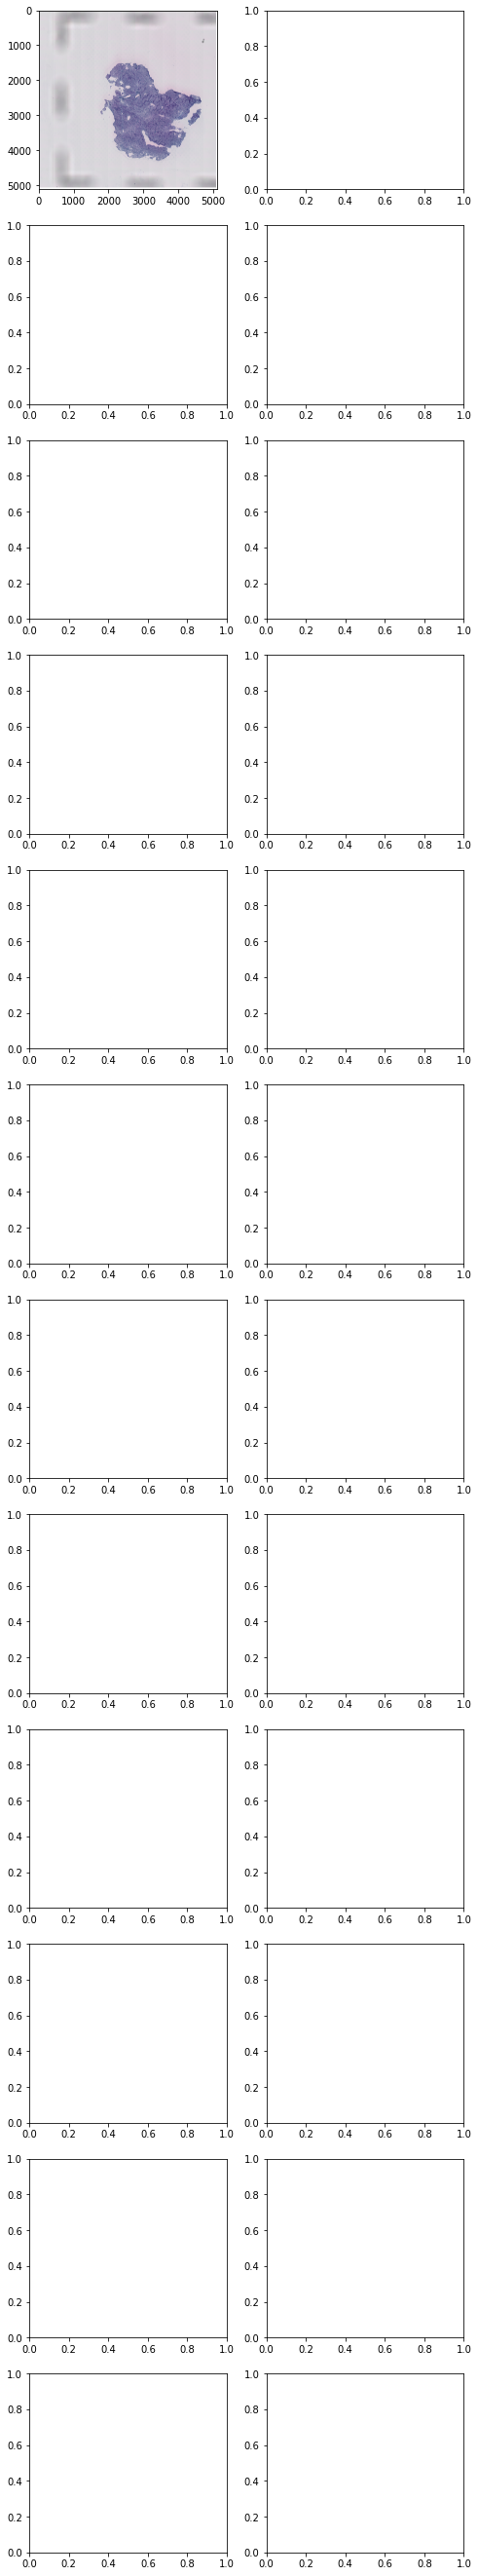

In [129]:
# instantiate plot
fig,ax = plt.subplots(len(data_set),2,
                      figsize = (4 * 2,4 * len(data_set)))

cmap = {"central":"red",
        "portal":"blue"}


for k,sample_id in enumerate(data_set.keys()):
  
    # convert predicted type to vector
    # with label for each pixel
    
    true_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    pred_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    
    idxs = data_set[sample_id].uns["mask"].id.values
    
    for idx in np.unique(idxs):
        sel = idxs == idx
        vein_id = sample_id + "_" + str(idx)
        pred_color[sel] = cmap[predict_all.loc[vein_id].values[0]]
        
    
    viz.plot_veins(ax[k,0],
                  data_set[sample_id],
                  alternative_colors = true_color,
                  show_image = True,
                  show_id = True,
                 )
    
    viz.plot_veins(ax[k,1],
                  data_set[sample_id],
                  alternative_colors = pred_color,
                  show_image = True,
                  show_id = True,
                 )
    
    # set titles
    ax[k,0].set_title("True",
                    fontsize = 20,)
    ax[k,1].set_title("Predicted",
                    fontsize = 20,)
    
    ax[k,0].set_ylabel(sample_id,
                       fontsize = 20)


if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"predict-all-hard.png"),
                facecolor = "white")
    
plt.show()